 # [Module 2.5] AutoGluon 훈련 및 추론

이 노트북은 아래와 같은 작업을 합니다.
- 훈련, 검증 합쳐서 훈련 데이터 생성 (물리적으로 훈련 + 검증)
- AutoGluon 데이터 타입으로 변경
- AutoGluon 훈련
- 테스트 데이터 로딩 및 추론
- 모델 평가
- 피쳐 Importance 생성

In [40]:
%store -r train_file
%store -r val_file
%store -r test_file

In [41]:
train_file

'preproc_data/non_feature_engineering/train.csv'

In [42]:
import autogluon.core as ag
from autogluon.tabular import TabularPrediction as task

## 기존 Train, Val을 합쳐서 Train 데이터 생성
오토 글루온은 내부적으로 데이터를 다시 훈련, 검증로 나누어서 사용하기에 입력시에 합쳐서 제공 함

In [43]:
import pandas as pd
from IPython.display import display
import os

def merge_train_val(train_file, val_file, save_file_name):
    train_df = pd.read_csv(train_file)
#     display(train_df.head())
    print('train_df: ', train_df.shape)
    val_df = pd.read_csv(val_file)
#     display(val_df.head())
    print('val_df: ', val_df.shape)    
    train_val_df = pd.concat([train_df, val_df], axis=0)
#     display(train_val_df.head())    
    print('train_val_df: ', train_val_df.shape)   
    train_val_df.to_csv(save_file_name, index=None)
    print(f'{save_file_name} is saved')
    
new_train_val_folder = 'preproc_data/non_feature_engineering/train_val'
os.makedirs(new_train_val_folder, exist_ok=True)
train_val_file_path = os.path.join(new_train_val_folder, 'train_val.csv')
    
merge_train_val(train_file, val_file, train_val_file_path)    

train_df:  (53740, 20)
val_df:  (13436, 20)
train_val_df:  (67176, 20)
preproc_data/non_feature_engineering/train_val/train_val.csv is saved


## 오토글루온 데이터 타입으로 변경

In [44]:
train_data = task.Dataset(file_path=train_val_file_path)
subsample_size = train_data.shape[0]
# subsample_size = 500  # subsample subset of data for faster demo, try setting this to much larger values
train_data = train_data.sample(n=subsample_size, random_state=0)
print(train_data.head())

Loaded data from: preproc_data/non_feature_engineering/train_val/train_val.csv | Columns = 20 / 20 | Rows = 67176 -> 67176


       classes            customer_city customer_state  \
8220         3  bom jesus do itabapoana             RJ   
36375        3                sao paulo             SP   
49981        4           belo horizonte             MG   
4599         2                    araxa             MG   
20806        2               petropolis             RJ   

       customer_zip_code_prefix product_category_name_english   price  \
8220                      28360                 health_beauty  349.90   
36375                      2316                bed_bath_table   29.99   
49981                     30360                    stationery   59.00   
4599                      38183                     telephony   99.90   
20806                     25745                bed_bath_table   37.99   

       freight_value  product_weight_g  product_volume  order_weekday  \
8220           20.02             900.0         11400.0              2   
36375          12.69             500.0          2560.0            

In [45]:
label_column = 'classes'
print("Summary of class variable: \n", train_data[label_column].describe())

Summary of class variable: 
 count    67176.000000
mean         2.088276
std          1.152390
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: classes, dtype: float64


## 오토글루운으로 훈련

In [46]:
%%time
dir = 'agModels-predictClass'  # specifies folder where to store trained models
time_limits = 7200 # seconds
# presets = 'best_quality'
presets = 'medium_quality_faster_train'

predictor = task.fit(train_data=train_data, label=label_column, 
                     output_directory=dir,
                     time_limits=time_limits,
                     presets=presets)



Beginning AutoGluon training ... Time limit = 7200s
AutoGluon will save models to agModels-predictClass/
AutoGluon Version:  0.0.15b20201025
Train Data Rows:    67176
Train Data Columns: 19
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	5 unique label values:  [3, 4, 2, 1, 0]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 5
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    64597.29 MB
	Train Data (Original)  Memory Usage: 22.31 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFe

CPU times: user 36min 8s, sys: 21min 25s, total: 57min 33s
Wall time: 3min 54s


## 테스트 데이터 로딩

In [47]:
test_data = task.Dataset(file_path=test_file)
y_test = test_data[label_column]  # values to predict
test_data_nolab = test_data.drop(labels=[label_column],axis=1)  # delete label column to prove we're not cheating
print(test_data_nolab.head())

Loaded data from: preproc_data/non_feature_engineering/test.csv | Columns = 20 / 20 | Rows = 13436 -> 13436


    customer_city customer_state  customer_zip_code_prefix  \
0       joinville             SC                     89219   
1         diadema             SP                      9950   
2     teresopolis             RJ                     25963   
3  rio de janeiro             RJ                     21330   
4         vitoria             ES                     29090   

  product_category_name_english   price  freight_value  product_weight_g  \
0                 watches_gifts  105.00          23.89            1000.0   
1                    housewares   99.97          15.80             650.0   
2               books_technical   76.99          23.34            1850.0   
3                    cool_stuff   64.90          15.55             200.0   
4               furniture_decor   75.00          27.51            2550.0   

   product_volume  order_weekday  order_day  order_month  \
0          7632.0              1         19            6   
1          9600.0              1         19       

## 모델 예측

In [48]:
predictor = task.load(dir)  # unnecessary, just demonstrates how to load previously-trained predictor from file

prediction = predictor.predict(test_data_nolab)
print("Predictions:  ", prediction)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=prediction, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.9606281631437928
Evaluations on test data:
{
    "accuracy": 0.9606281631437928,
    "accuracy_score": 0.9606281631437928,
    "balanced_accuracy_score": 0.9556667903446845,
    "matthews_corrcoef": 0.9470406146656493
}
Detailed (per-class) classification report:
{
    "0": {
        "precision": 0.9532062391681109,
        "recall": 0.967741935483871,
        "f1-score": 0.9604190919674039,
        "support": 1705
    },
    "1": {
        "precision": 0.966674716252113,
        "recall": 0.9617972128784238,
        "f1-score": 0.9642297964591111,
        "support": 4162
    },
    "2": {
        "precision": 0.9534531283827669,
        "recall": 0.9711135611907387,
        "f1-score": 0.9622023159274634,
        "support": 4535
    },
    "3": {
        "precision": 0.9658767772511848,
        "recall": 0.9400369003690037,
        "f1-score": 0.9527816736792895,
        "support": 2168
    },
    "4": {
        "precision": 0.9724550898203593,
   

Predictions:   [3 0 3 ... 0 0 0]


## 리더 보드 생성

In [49]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestClassifierGini,0.981244,0.8780,0.475134,0.112322,2.060318,0.475134,0.112322,2.060318,0,True,4
1,RandomForestClassifierEntr,0.980575,0.8720,0.358938,0.111547,3.155216,0.358938,0.111547,3.155216,0,True,5
2,ExtraTreesClassifierGini,0.980351,0.8532,1.873606,0.111600,1.368804,1.873606,0.111600,1.368804,0,True,6
3,ExtraTreesClassifierEntr,0.980128,0.8528,2.129753,0.111518,1.679223,2.129753,0.111518,1.679223,0,True,7
4,KNeighborsClassifierDist,0.975067,0.3092,0.458322,0.109524,0.380216,0.458322,0.109524,0.380216,0,True,3
5,weighted_ensemble_k0_l1,0.960628,0.8864,4.246780,0.556648,198.839401,0.019392,0.000819,0.550756,1,True,12
6,LightGBMClassifierCustom,0.707130,0.8792,0.056426,0.011927,1.964048,0.056426,0.011927,1.964048,0,True,11
7,NeuralNetClassifier,0.622581,0.8744,1.207137,0.208515,189.429840,1.207137,0.208515,189.429840,0,True,1
8,KNeighborsClassifierUnif,0.568026,0.3112,0.527353,0.109683,0.384437,0.527353,0.109683,0.384437,0,True,2
9,LightGBMClassifierXT,0.561625,0.8576,0.072027,0.017100,1.564744,0.072027,0.017100,1.564744,0,True,9


## 모델 평가

In [50]:
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, prediction)
f1_score = f1_score(y_test, prediction, average='macro')
print("accuracy: %.2f%%" % accuracy)
print("f1_score: %.2f%%" % f1_score)

accuracy: 0.96%
f1_score: 0.96%


[[1650   34   18    2    1]
 [  42 4003   93   21    3]
 [  24   56 4404   38   13]
 [  12   34   78 2038    6]
 [   3   14   26   11  812]]


<Figure size 432x288 with 0 Axes>

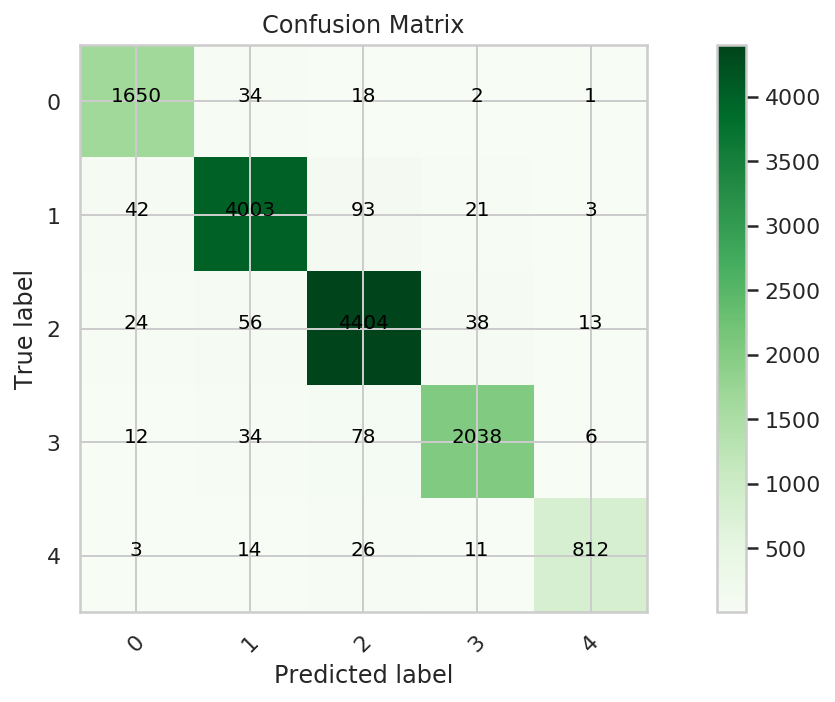

In [51]:
from utils import plot_conf_mat


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

cm = confusion_matrix(y_true= y_test, y_pred= prediction)

plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(cm, 
              classes=['0','1', '2', '3', '4'], 
              title='Confusion Matrix')
plt.show()

## Feature Importance

Computing raw permutation importance for 19 features on weighted_ensemble_k0_l1 ...
	65.06s	= Expected runtime
	68.56s	= Actual runtime


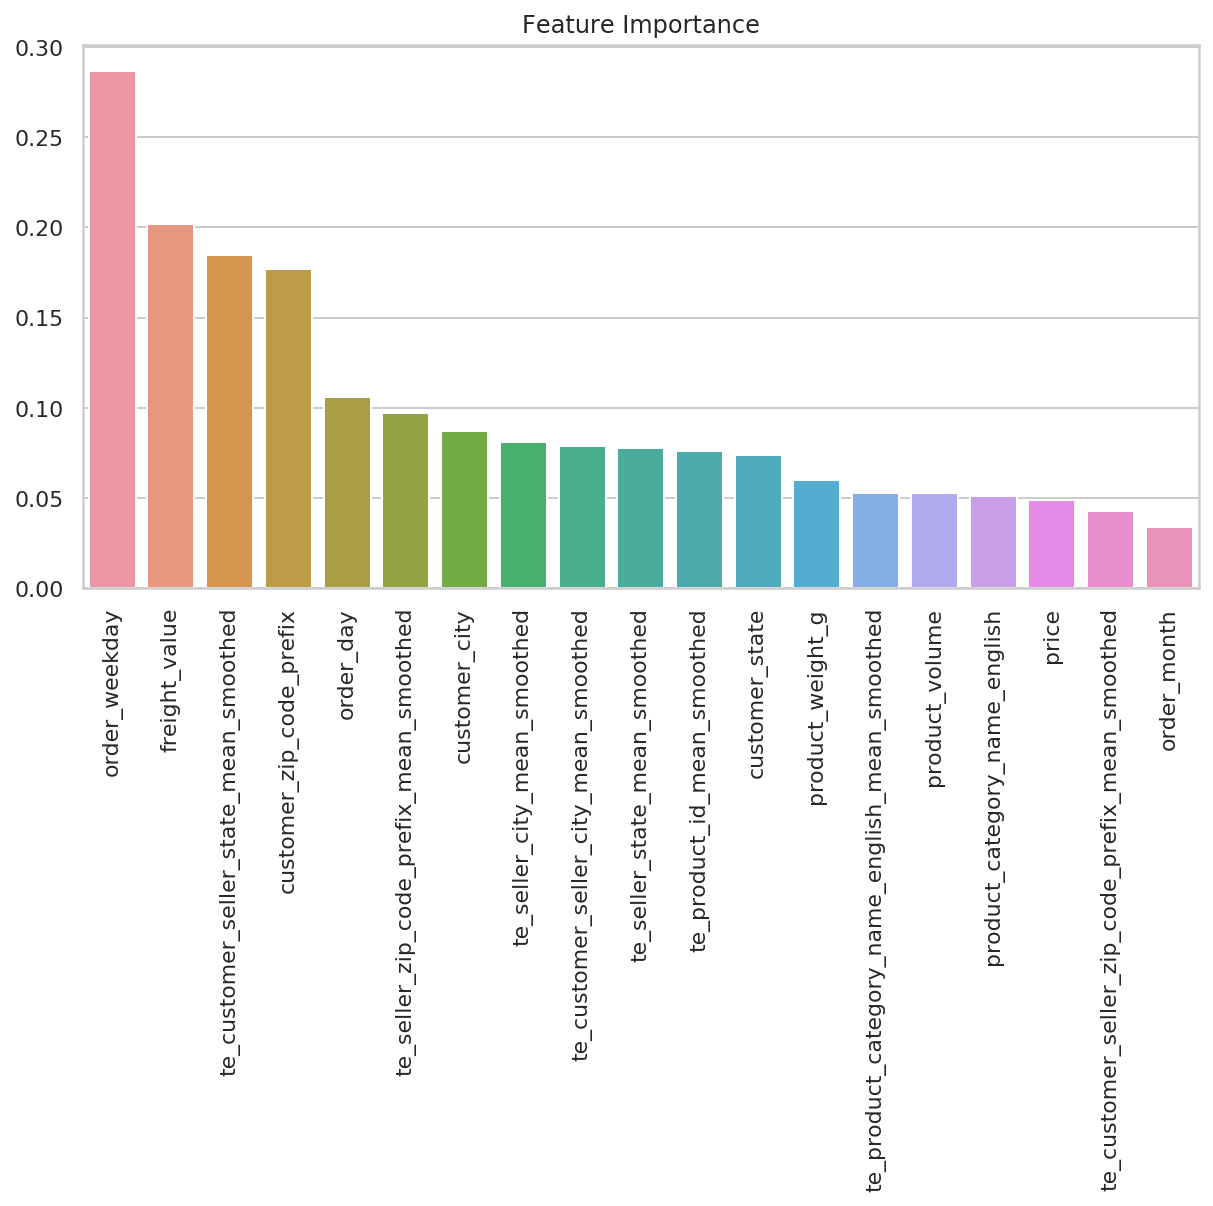

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

fea_importance = predictor.feature_importance(test_data)

f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=fea_importance.index, y = fea_importance.values)
# plot = sns.barplot(x=features, y= fea_importance)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()